# **STMO Project**
### Dilara Ağacik, Robbe Fonteyn, Kaan Turker

### Introduction

The aim of our project is to optimize a running route through Ghent. We evaluate three different algorithms for this purpose:

- Brute Force (BF)
- Genetic Algorithm (GA)
- Simulated Annealing (SA)

For this project, a running route fulfills these requirements:
- The route should start at a specified location
- The path should pass through predifined points of interest (POIs)
- The total length of the path should approach a specified distance
- The route needs to be a round trip, meaning it ends where it started

## Load in Libraries

We will approach this problem using the [osmnx package](https://osmnx.readthedocs.io/en/stable/), [networkx package](https://networkx.org/documentation/stable/) and [Geopy package](https://geopy.readthedocs.io/en/stable/).

Here is some information about the packages from their documentation pages:  
**OSMnx** is a Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap. You can download and model walking, driving, or biking networks with a single line of code then analyze and visualize them. You can just as easily work with urban amenities/points of interest, building footprints, transit stops, elevation data, street orientations, speed/travel time, and routing.

**NetworkX** is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.

**Geopy** is a Python client for several popular geocoding web services.
Geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

In [1]:
import os
import osmnx as ox
import networkx as nx
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from ipywidgets import interact, IntSlider
from itertools import permutations
from random import choice, random
import random
import helpfunctions
import time

## Graph Setup and Exploration

Firstly we need a graph of Ghent to calculate and plot our running routes with. The way we generate the graph is by specifying a central point and a radius of 2500 meters. The package will download the graph information based on these specifications and store locally for easy access.

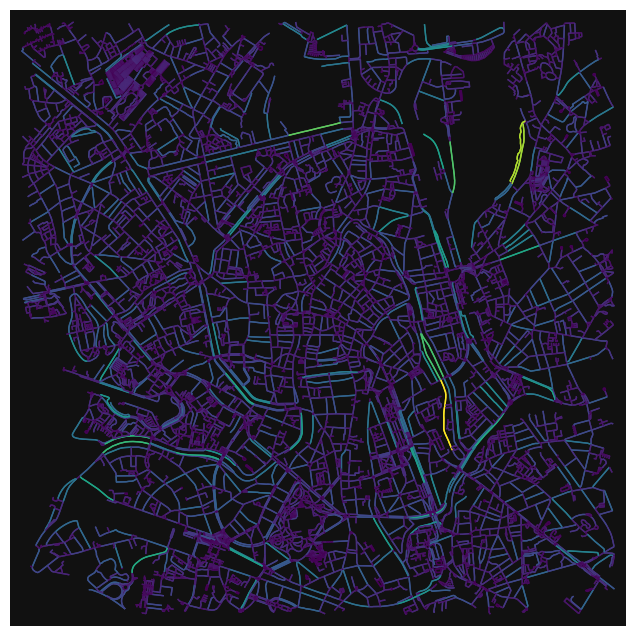

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
file_path = "data/graph.graphml"
geolocator = Nominatim(user_agent="STMO_project", timeout=10)

if not os.path.exists(file_path):

    # Define the address as a starting point
    center = "Cataloniëstraat 4, 9000 Gent"

    # Geocode the address to get its latitude and longitude
    center_point = ox.geocode(center)

    # Define the buffer distance (in meters) for the map area
    buffer_distance = 2500  # Meters radius from center point

    # Download the street network data within the buffer distance around the center point
    graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')
    graph = ox.distance.add_edge_lengths(graph)

    # Save the current plot
    ox.io.save_graphml(graph)

else:
    graph = ox.io.load_graphml(file_path)

# Plot the graph to verify
ec = ox.plot.get_edge_colors_by_attr(graph, attr='length')
ox.plot_graph(graph, edge_color=ec, node_alpha=0)

The output diagram illustrates the graph we generated, with all the edges coloured by their length.

In [3]:
city_nodes, city_edges = ox.graph_to_gdfs(graph)

In [4]:
city_edges.head()

osmid  \
u      v           key                                                      
145763 10608884795 0    [237303363, 658608134, 242016456, 12141436, 12...   
       1679740532  0                               [713177181, 242016455]   
       11958115602 0                                 [5898941, 762813039]   
145785 31366176    0                                             38910101   
       1788439106  0                                            292166160   

                            highway   lanes maxspeed  \
u      v           key                                 
145763 10608884795 0       tertiary       2       50   
       1679740532  0       tertiary  [2, 3]       50   
       11958115602 0    residential     NaN      NaN   
145785 31366176    0        primary       2       50   
       1788439106  0        primary       3       50   

                                                             name  oneway  \
u      v           key                                                      
145763 10608884795 0    [Burggravenlaan, Achilles Heyndrickxlaan]   False   
       1679740532  0                               Burggravenlaan   False   
       11958115602 0                               Burggravenlaan   False   
145785 31366176    0                          Fernand Scribedreef   False   
       1788439106  0                      Charles de Kerchovelaan   False   

                       reversed      length bridge  \
u      v           key                               
145763 10608884795 0       True  305.044403    yes   
       1679740532  0      False  143.045927    NaN   
       11958115602 0       True  133.674344    NaN   
145785 31366176    0      False   34.553655    NaN   
       1788439106  0       True   22.516021    NaN   

                                                                 geometry  \
u      v           key                                                      
145763 10608884795 0    LINESTRING (3.73225 51.03183, 3.73237 51.03185...   
       1679740532  0    LINESTRING (3.73225 51.03183, 3.7318 51.03176,...   
       11958115602 0    LINESTRING (3.73225 51.03183, 3.73232 51.0319,...   
145785 31366176    0      LINESTRING (3.72518 51.03864, 3.72469 51.03864)   
       1788439106  0    LINESTRING (3.72518 51.03864, 3.72501 51.03874...   

                        ref width junction access tunnel service  
u      v           key                                            
145763 10608884795 0    NaN   NaN      NaN    NaN    NaN     NaN  
       1679740532  0    NaN   NaN      NaN    NaN    NaN     NaN  
       11958115602 0    NaN   NaN      NaN    NaN    NaN     NaN  
145785 31366176    0    N60   NaN      NaN    NaN    NaN     NaN  
       1788439106  0    R40   NaN      NaN    NaN    NaN     NaN

In [5]:
city_nodes.head()

,y,x,street_count,highway,railway,ref,geometry
osmid,,,,,,,
145763,51.031829,3.732254,3,NaN,NaN,NaN,POINT (3.73225 51.03183)
145785,51.038644,3.725182,3,NaN,NaN,NaN,POINT (3.72518 51.03864)
145786,51.039828,3.723309,4,NaN,NaN,NaN,POINT (3.72331 51.03983)
145787,51.039805,3.722999,3,NaN,NaN,NaN,POINT (3.723 51.03981)
145789,51.053930,3.730887,4,NaN,NaN,NaN,POINT (3.73089 51.05393)


## Package Testing

Because we are unfamiliar with these packages, we first explore a simple implementation where we want to just plot a route through the graph. The route is required to be at least 3000 ± 50 meters from a specific start point, but we don't specify an ending address. This small example uses **Dijkstra's** shortest path algorithm to calculate the quickest route a node which is 3 km away.

Number of possible nodes 410


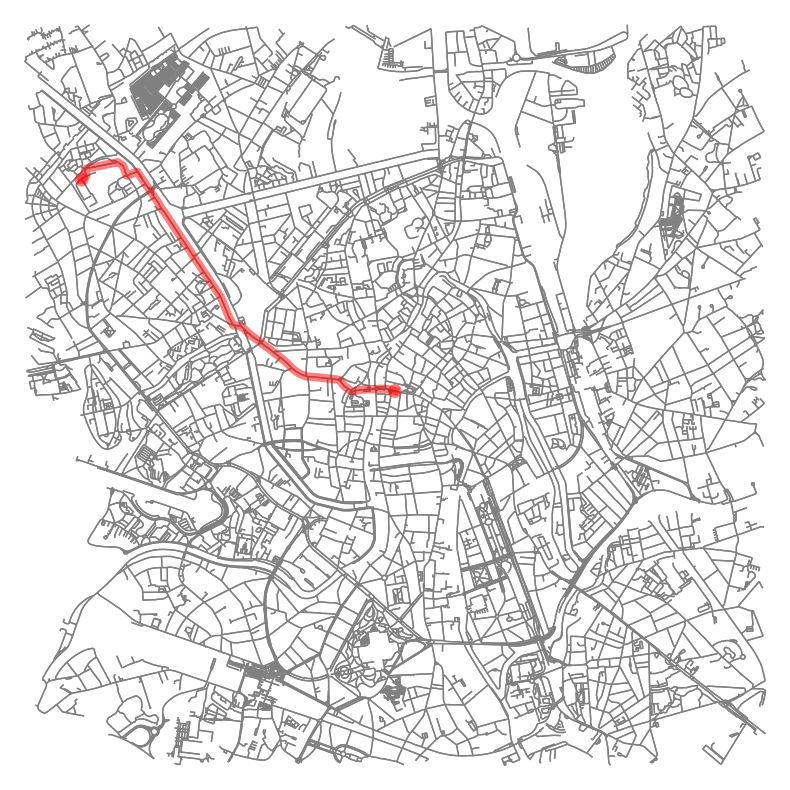

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [6]:
# Define a start address:
start_address = "Cataloniëstraat 4, 9000 Gent"

start_node = helpfunctions.translate_address(graph, geolocator, start_address, False)

# Run Dijkstra's algorithm to get the shortest paths from the start node
distances, predecessors = nx.single_source_dijkstra(graph, source=start_node, weight='length')  # 'length' is the edge attribute for distance

# Set target distance
target_distance = 3000  # in meters
threshold = 50  # in meters (± 50 meters)

# Filter nodes that are within the threshold distance
close_nodes = {node: distance for node, distance in distances.items() if abs(distance - target_distance) <= threshold}
print("Number of possible nodes", len(close_nodes))

# Select a target node, the one that is about 5 km away (choose any from close_nodes)
target_node = list(close_nodes.keys())[0]  # Select the first node (or choose based on your preference)

# Get the specific route between start_node and target_node
route = nx.shortest_path(graph, source=start_node, target=target_node, weight='length')

# Visualize the route on the map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the full graph
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)
# Plot the specific route
ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='white', ax=ax, show=True)


## Optimization Algorithms

These points of interest will be used as an input to all of the algorithms, they are common tourist spots in Ghent.

In [7]:
points_of_interest = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Museum of Industry": "Minnemeers 10, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium",
    "St. Bavo's Cathedral": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Ghent University Botanical Garden": "Karel Lodewijk Ledeganckstraat 35, 9000 Gent, Belgium",
    "STAM Ghent City Museum": "Godshuizenlaan 2, 9000 Gent, Belgium",
    "Design Museum Gent": "Jan Breydelstraat 5, 9000 Gent, Belgium" 
}

nodes_to_visit = {}
for monument in points_of_interest.keys():
    current = points_of_interest[monument]
    nodes_to_visit[monument] = helpfunctions.translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

Nodes dict: {'Gravensteen': 599296037, 'Museum of Industry': 4580267383, 'Sint Rita': 1128900973, 'Lievekaai': 82778718, "St. Bavo's Cathedral": 7293338633, 'Ghent University Botanical Garden': 10962332866, 'STAM Ghent City Museum': 26268461, 'Design Museum Gent': 1212148854}


The cell below specifies the input for every algorithm we will implement. We will give each algorithm the same input so we can compare them fairly at the end.

In [8]:
start_address = "Coupure Links 653, 9000 Gent"
start_node = {"UGent Campus Coupure": helpfunctions.translate_address(graph, geolocator, start_address)}
target_distance = 10000 # 10km

### Brute Force

In [9]:
# Brute Force Algorithm
def brute_force_algorithm(graph, nodes, start_node, target_distance, threshold=50, verbose=0):
    """
    Run the brute force algorithm to find the optimal path.

    Parameters:
    ----------
    graph : networkx.Graph
        The graph representing the network.
    nodes : dict
        Dictionary of nodes to visit.
    start_node : int
        The starting node in the graph.
    target_distance : float
        The target distance for the path.
    threshold : float, optional
        The allowed deviation from the target distance.
    verbose : int, optional
        Verbosity level.

    Returns:
    -------
    tuple
        The best path, best length, history, and best lengths.
    """
    nodes = list(nodes.values())
    valid_permutations = []
    for perm in permutations(nodes):
        path = [start_node] + list(perm) + [start_node]
        if all(nx.has_path(graph, path[i], path[i + 1]) for i in range(len(path) - 1)):
            valid_permutations.append(perm)

    best_path, best_length = None, float('inf')
    history, best_lengths = [], []

    for generation, perm in enumerate(valid_permutations):
        path = [start_node] + list(perm) + [start_node]

        # Evaluate path length
        current_length = helpfunctions.calculate_route_distance(graph, path)
        history.append((path, current_length))

        if abs(current_length - target_distance) <= threshold and current_length < best_length:
            best_path, best_length = path, current_length

        best_lengths.append(best_length)

        if verbose:
            print(f"Generation {generation}: Path {path} | Length = {current_length:.2f}")

    return best_path, best_length, history, best_lengths

In [27]:
%%time
best_path_BF, best_length_BF, history_BF, best_lengths_BF = brute_force_algorithm(
    graph=graph, 
    nodes=nodes_to_visit, 
    start_node=start_node['UGent Campus Coupure'], 
    target_distance=target_distance,  
    threshold=100, 
    verbose=0
)

print("Best Path:", best_path_BF)
print("Path Length:", best_length_BF)


Best Path: [8681159626, 82778718, 4580267383, 1128900973, 7293338633, 1212148854, 599296037, 10962332866, 26268461, 8681159626]
Path Length: 9900.328362076765
CPU times: total: 58min 34s
Wall time: 59min 24s


In [ ]:
#Best solution found by brute force
#Best Path: [8681159626, 82778718, 4580267383, 1128900973, 7293338633, 1212148854, 599296037, 10962332866, 26268461, 8681159626]
#Path Length: 9900.328362076765
#CPU times: total: 58min 34s
#Wall time: 59min 24s

As the **BF** method is an exhaustive search, it will explore all the possible permutations of nodes and output a very good solution as expected. The algorithm is very computationally expensive especially for large input sizes. This approach is not suitable for problems with large search spaces.

### Genetic Algorithm

In [11]:
# Fitness Function
# The fitness function evaluates how close the total length of a path is to the target distance
def fitness(graph, path, target_distance):
    if len(set(path[:-1])) != len(path[:-1]):  # Check for vertex reuse excluding the start/end node
        return float('-inf')  # Penalize paths that reuse vertices

    path_length = 0
    edges_seen = set()

    for i in range(len(path) - 1):
        try:
            edge = (path[i], path[i + 1])
            reverse_edge = (path[i + 1], path[i])
            if edge in edges_seen or reverse_edge in edges_seen:  # Check for edge reuse
                return float('-inf')  # Penalize paths that reuse edges

            edges_seen.add(edge)
            path_length += nx.shortest_path_length(graph, path[i], path[i + 1], weight='length')
        except nx.NetworkXNoPath:
            return float('-inf')  # Penalize paths with missing connections

    # Penalize paths that exceed the target distance
    return -abs(target_distance - path_length) - (0.1 * max(0, path_length - target_distance))


In [12]:
# Crossover
# Combine two parent paths to create an offspring path
def crossover(parent1, parent2):
    split_idx = random.randint(1, len(parent1) - 2)
    middle_section = [node for node in parent2 if node not in parent1[:split_idx]]
    child = parent1[:split_idx] + middle_section
    return child

In [13]:
# Mutation
# Introduce small changes to paths
def mutate(path):
    idx1, idx2 = random.sample(range(1, len(path) - 2), 2)  # Avoid start and end nodes
    path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

In [14]:
# Initialize Population
# Generate random paths:
def initialize_population(start_node_id, node_ids, population_size):
    population = []
    for _ in range(population_size):
        path = node_ids[:]  # Copy the list of node IDs
        random.shuffle(path)
        path = [start_node_id] + path + [start_node_id]  # Add start and end node to complete the round trip
        population.append(path)
    return population

In [15]:
def genetic_algorithm(graph, nodes, start_node, target_distance, mutation_rate=0.1, population_size=100, generations=200, early_stopping_rounds=10, verbose=0):
    start_node_id = list(start_node.values())[0]  # Get the start node ID
    node_ids = list(nodes.values())  # Convert nodes dictionary to a list of node IDs

    population = initialize_population(start_node_id, node_ids, population_size)
    history = []  # To store the best path of each generation
    best_lengths = []  # To store the best lengths of each generation
    best_path = None
    best_length = float('inf')
    no_improvement_rounds = 0  # Counter for early stopping

    for generation in range(generations):
        population_fitness = []
        for path in population:
            # Enforce the no-reuse constraint
            if len(set(path)) != len(path):
                fitness_value = float('-inf')  # Penalize paths that reuse vertices
            else:
                fitness_value = fitness(graph, path, target_distance)
            population_fitness.append((path, fitness_value))

        population_fitness.sort(key=lambda x: x[1], reverse=True)

        current_best_path, _ = population_fitness[0]
        history.append(current_best_path)

        current_length = sum(
            nx.shortest_path_length(graph, current_best_path[i], current_best_path[i + 1], weight='length')
            for i in range(len(current_best_path) - 1)
        )
        best_lengths.append(current_length)

        if abs(target_distance - current_length) < abs(target_distance - best_length):
            best_path = current_best_path
            best_length = current_length
            no_improvement_rounds = 0
        else:
            no_improvement_rounds += 1

        if no_improvement_rounds >= early_stopping_rounds:
            print(f"Early stopping at generation {generation} due to no improvement in last {early_stopping_rounds} generations.")
            break

        if verbose == 1:
            print(f"Generation: [{generation+1}/{generations}] --- Best path: {population_fitness[0][0]} with length: {best_length}")
        else:
            print(f"Generation: [{generation+1}/{generations}] --- Best length: {best_length}")

        parents = [path for path, _ in population_fitness[:population_size // 2]]
        next_generation = parents[:]
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:  # Mutation probability
                child = mutate(child)
            next_generation.append(child)

        population = next_generation

    return best_path, best_length, history, best_lengths

In [16]:
%%time
best_path_GA, best_length_GA, history_GA, best_lengths_GA = genetic_algorithm(
    graph = graph, 
    nodes = nodes_to_visit, 
    start_node = start_node, 
    target_distance = target_distance, 
    generations = 100, population_size=200, 
    mutation_rate=0.1, early_stopping_rounds=10
)
print("Best Path:", best_path_GA)
print("Path Length:", best_length_GA)

Generation: [1/100] --- Best length: 12758.617393441915
Generation: [2/100] --- Best length: 9998.590141469322
Generation: [3/100] --- Best length: 9998.590141469322
Generation: [4/100] --- Best length: 9998.590141469322
Generation: [5/100] --- Best length: 9998.590141469322
Generation: [6/100] --- Best length: 9998.590141469322
Generation: [7/100] --- Best length: 9998.590141469322
Generation: [8/100] --- Best length: 9998.590141469322
Generation: [9/100] --- Best length: 9998.590141469322
Generation: [10/100] --- Best length: 9998.590141469322
Generation: [11/100] --- Best length: 9998.590141469322
Early stopping at generation 11 due to no improvement in last 10 generations.
Best Path: [8681159626, 82778718, 1128900973, 1212148854, 7293338633, 4580267383, 26268461, 10962332866, 599296037]
Path Length: 9998.590141469322
CPU times: total: 2min 20s
Wall time: 2min 25s


We use the Genetic Algorithm (GA) as a heuristic approach to solve the problem. We define fitness, selection, crossover and mutation to mimic the process of natural selection. 

The **fitness** function here evaluates the length of the route and it will optimize based on this. The closer it is to our target distance (10 km), the higher the fitness.  

**Crossover** in this implementation works by selecting two parents which are represented by a list of nodes, from which a random split point is chosen in the first parent. The child sequence starts by taking all elements from the first parent up to this split point. Then, the second parent is filtered to exclude any elements already in the child's initial segment, ensuring no duplicates. The filtered portion of the second parent is appended to the child, creating a new sequence that blends traits from both parents while maintaining uniqueness and validity.

Example if the split is 2.  
- Parent 1: [A, B, C, D, E]  
- Parent 2: [E, D, C, B, A]  
- Child: [A, B, E, D, C]  

**Mutation** in this genetic algorithm works by specifying a mutation rate as a float. Looping through each member of the population, a random number is generated and if this is lower than the rate, the function will randomply switch arround the order of two nodes in the list of the population member.

Example if mutation rate is 0.1.  
- member: [A, B, C, D, E] -> Random number = 0.02 -> New member: [A, B, C, E, D]  

The algorithm will perform **selection** based on the top 50% of the best fitness paths. These are the parents of the next generation.  

### Simulated Annealing

In [18]:
def simulated_annealing(graph, poi_coords, start_node, max_iterations=1000, initial_temp=1000, cooling_rate=0.99, target_distance=None, penalty_factor=10):
    """
    Simulated Annealing to find an optimized route visiting all points of interest (POIs) while targeting a specific distance.

    Parameters:
    -----------
    graph : networkx.MultiDiGraph
        The road network graph.
    poi_coords : list
        List of POI nodes to visit.
    start_node : int
        The starting node in the graph.
    max_iterations : int
        Maximum number of iterations.
    initial_temp : float
        Starting temperature for the annealing process.
    cooling_rate : float
        Rate at which the temperature decreases.
    target_distance : float, optional
        The desired total route distance. If provided, the optimization will aim for this distance.
    penalty_factor : float
        Factor to penalize deviation from the target distance.

    Returns:
    --------
    best_route : list
        Optimized route as a sequence of nodes.
    best_distance : float
        Distance of the best route.
    """
    # Initialize variables
    current_route = [start_node] + poi_coords + [start_node]  # Start and end at the same node
    best_route = current_route[:]
    best_distance = helpfunctions.calculate_route_distance(graph, current_route)

    current_temp = initial_temp

    for iteration in range(max_iterations):
        # Create a new route by swapping two random POIs (excluding start/end nodes)
        new_route = current_route[:]
        i, j = np.random.choice(range(1, len(poi_coords) + 1), size=2, replace=False)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        # Calculate the distances of the current and new routes
        current_distance = helpfunctions.calculate_route_distance(graph, current_route)
        new_distance = helpfunctions.calculate_route_distance(graph, new_route)

        # If target distance is specified, adjust the objective function with a penalty
        if target_distance is not None:
            current_penalty = penalty_factor * abs(current_distance - target_distance)
            new_penalty = penalty_factor * abs(new_distance - target_distance)
            current_distance += current_penalty
            new_distance += new_penalty

        # Decide whether to accept the new route
        if new_distance < current_distance or random.random() < exp(-(new_distance - current_distance) / current_temp):
            current_route = new_route[:]

            # Update the best route if the new one is better
            if new_distance < best_distance:
                best_route = new_route[:]
                best_distance = new_distance

        # Cool down the temperature
        current_temp *= cooling_rate

        # Early stopping if temperature is too low
        if current_temp < 1e-3:
            break

    return best_route, best_distance


In [19]:
%%time
best_route_SA_T, best_distance_SA_T = simulated_annealing(
       graph,
    list(nodes_to_visit.values()),
    start_node['UGent Campus Coupure'],  
    max_iterations=1000,
    initial_temp=1000,
    cooling_rate=0.99,
    target_distance=10000)

print("Best Route (Node IDs):", best_route_SA_T)
print("Best Distance (meters):", best_distance_SA_T)

Best Route (Node IDs): [8681159626, 1212148854, 4580267383, 599296037, 1128900973, 82778718, 7293338633, 26268461, 10962332866, 8681159626]
Best Distance (meters): 10211.607393885486
CPU times: total: 1min 58s
Wall time: 2min


In [32]:
%%time
best_route_SA, best_distance_SA = simulated_annealing(
       graph,
    list(nodes_to_visit.values()),
    start_node['UGent Campus Coupure'],  
    max_iterations=1000,
    initial_temp=1000,
    cooling_rate=0.99)

print("Best Route (Node IDs):", best_route_SA)
print("Best Distance (meters):", best_distance_SA)

Best Route (Node IDs): [8681159626, 26268461, 10962332866, 7293338633, 4580267383, 599296037, 1128900973, 82778718, 1212148854, 8681159626]
Best Distance (meters): 8444.797948684442
CPU times: total: 1min 42s
Wall time: 1min 49s


Finaly, we used a Simulated annealing approach to explore the solution space via probabilistically excepting worse solutions. This allows to escape local optima and has a higher chance to find near global optimal solutions.

Accepting a worse solution is done by generating a random number and evaluating the following expression:

$$P = e^{\frac{\Delta E}{kT}}$$

As the system cools down, the temperature decreases and so it will be harder to accept worse solutions.

## Comparison of Algorithms

First we compare the algorithms without enforcing the target distance in Simulated annealing.

In [21]:
#best_path_BF = [8681159626, 26268461, 10962332866, 498848408, 4580267383, 599296037, 1128900973, 82778718, 1212148854, 8681159626]
#best_length_BF = 8511.742856726625

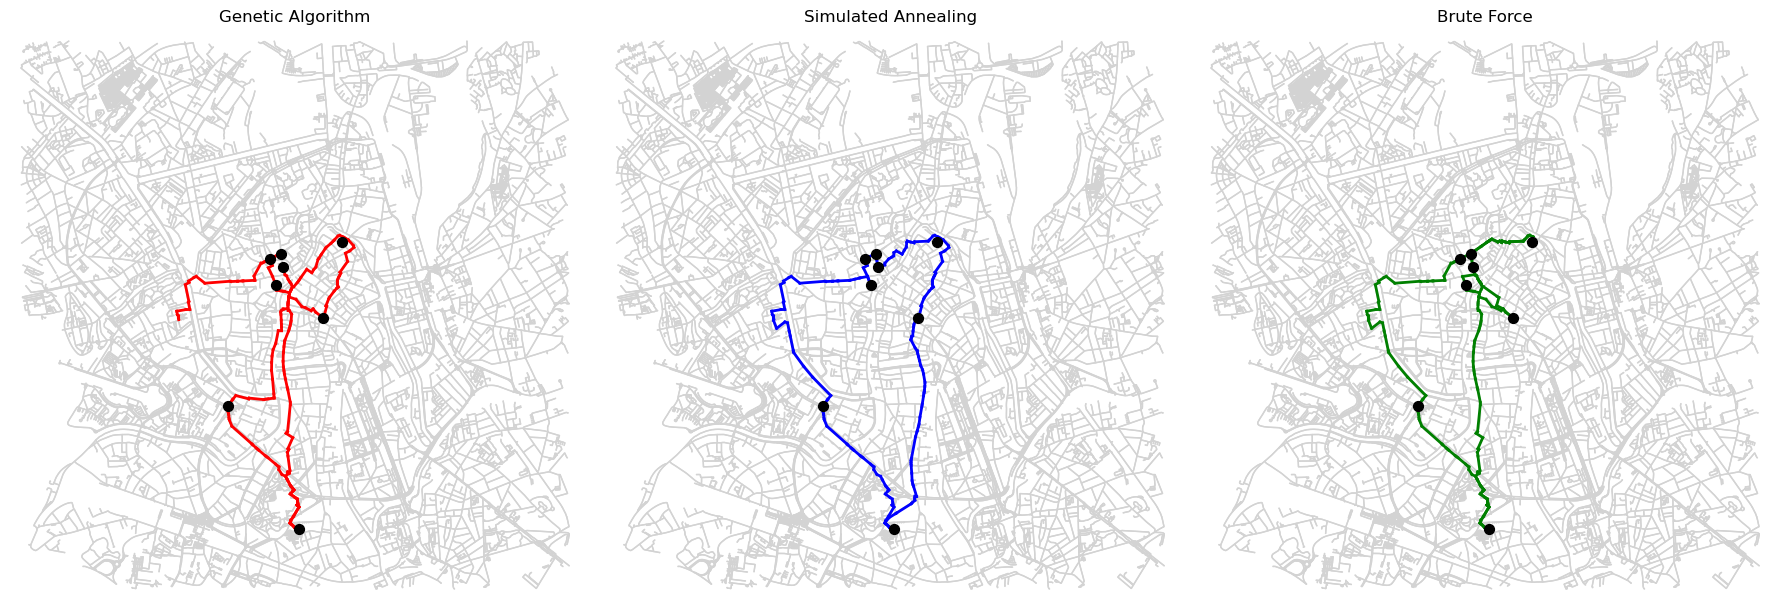

In [28]:
helpfunctions.plot_routes_separately(graph, [best_path_GA, best_route_SA, best_path_BF], route_labels=["Genetic Algorithm", "Simulated Annealing", "Brute Force"], locations_of_interest=points_of_interest)

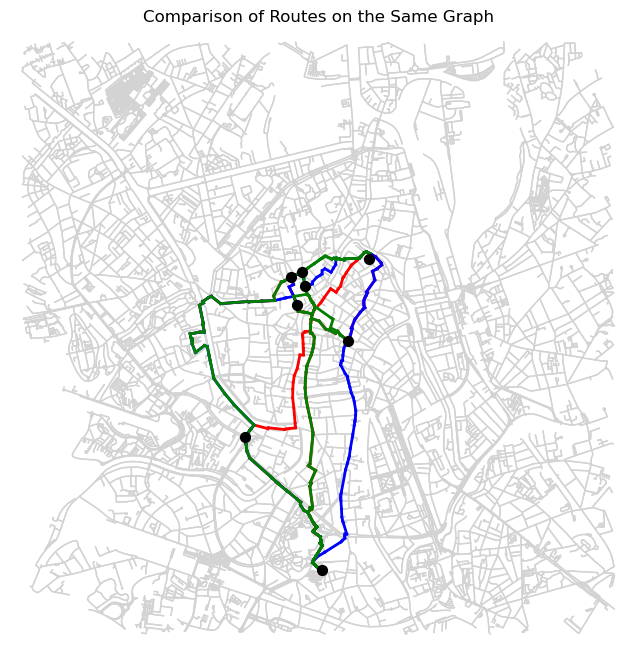

In [29]:
helpfunctions.plot_routes(graph, [best_path_GA, best_route_SA, best_path_BF], route_labels=["Genetic Algorithm", "Simulated Annealing", "Brute Force"], locations_of_interest=points_of_interest)

Now we compare the routes with Simulated Annealing holding to the target constraints.

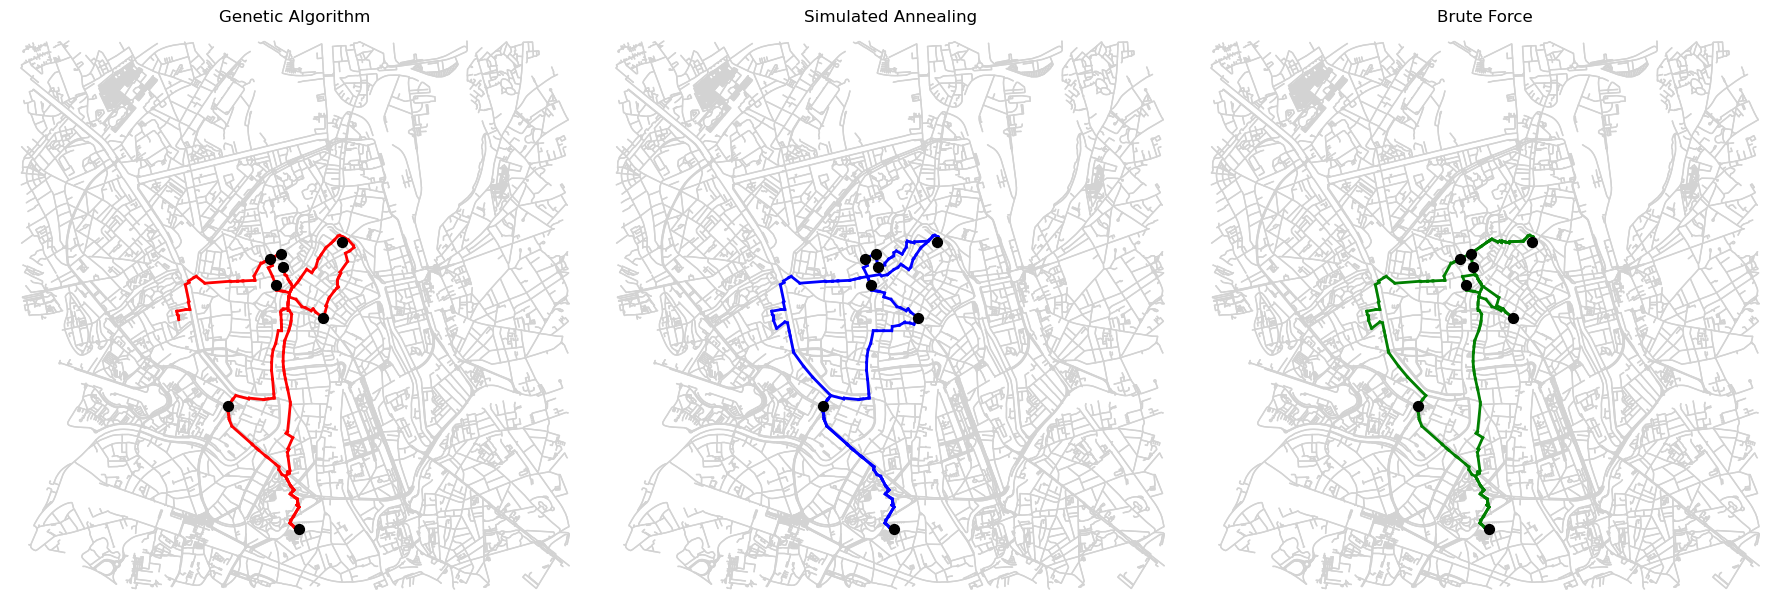

In [30]:
helpfunctions.plot_routes_separately(graph, [best_path_GA, best_route_SA_T, best_path_BF], route_labels=["Genetic Algorithm", "Simulated Annealing", "Brute Force"], locations_of_interest=points_of_interest)

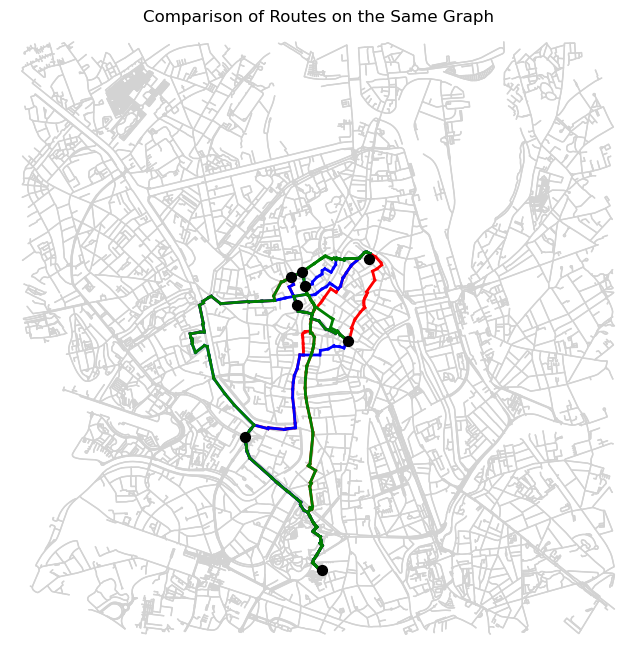

In [31]:
helpfunctions.plot_routes(graph, [best_path_GA, best_route_SA_T, best_path_BF], route_labels=["Genetic Algorithm", "Simulated Annealing", "Brute Force"], locations_of_interest=points_of_interest)

## Discussion of results

In this section, the comparison of the algorithms is discussed. As expected, the Brute Force algorithm took the most time compared to the Genetic Algorithm and Simulated Annealing, with a runtime around 1 hour. In the end it found a valid path with length of 9900.33 meters, as it evaluates all possible route permutations to guarantee the optimal solution. However, its high computational cost makes it impractical for larger datasets.  

On the other hand, Simulated Annealing provided an equally valid solution with a path length of 8444.79 meters if we loosen the distance constraint, the computational time of 1 minute and 53 seconds. While not guaranteed to find the global optimum, it effectively balances accuracy and runtime by probabilistically exploring solutions and escaping local optima. However, it required careful tuning of parameters, such as the initial temperature and cooling rate, to achieve good results. Taking into account the target distance constraint, it found a path through all the points of interest that is about 10211.61 meters long, in about 2 minutes.   

Lastly, the Genetic Algorithm, with a runtime of 2 minutes and 2 seconds and a path length of 9998.59 meters, showed scalability and robustness, making it suitable for larger datasets. However, it did not guarantee the global optimum and produced a less accurate solution compared to the other methods. Despite this, it remains a good choice for problems where computational constraints and the ability to handle larger solution spaces are prioritized. It also didn't make a round trip like the other algorithms did, and it also reused some streets, which is less desirable. However the length of the path is almost exactly the target distance.

Comparing the three algorithms to each other, there is a bit of difference in their solutions. We can see mainly in the part of the graph where a lot of points of interest are close to each other. With more parameter tuning (cooling rate, initial temperature, thresholds, population size, etc.) the results might have looked even better and more realistic for a running route through Ghent.  